In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
#%matplotlib notebook
import cmcrameri.cm as cmc  #scientific color maps - perceptually uniform
from scipy import signal
from scipy.optimize import fsolve
from scipy.stats import norm
from sklearn.preprocessing import normalize
import cmcrameri.cm as cmc  #scientific color maps - perceptually uniform
from scipy import constants
import numpy as np
import pandas as pd


<Axes: >

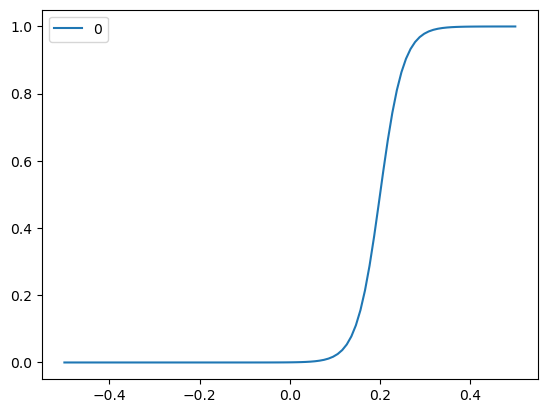

In [ ]:

def Gau(x: np.array, mu: float, sigma: float | int) -> np.array:
    return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma)**2)

def calcaulate_theta(U0: float, U: np.array) -> np.array:
    R = constants.R
    F = constants.physical_constants['Faraday constant'][0]  # Extract the numerical value
    T_K = 298.15
    exp_fun = np.exp(((U - U0) * F) / (R * T_K))
    return exp_fun / ( exp_fun + 1)

def evolve_component(theta:np.array, C0:float, spectrum:np.array, product_bool:bool, stoic_coef:float) -> np.array:
    if product_bool:
        return theta * C0 * spectrum * stoic_coef
    else:
        return (1 - theta) * C0 * spectrum
    
U = np.linspace(-0.5, 0.5, 100)
pd.DataFrame(calcaulate_theta(U0=0.2, U=U), index=U).plot()

Text(0, 0.5, ' $\\epsilon \\ (dm^3 \\ mol^{-1} \\ cm^{-1})$ ')

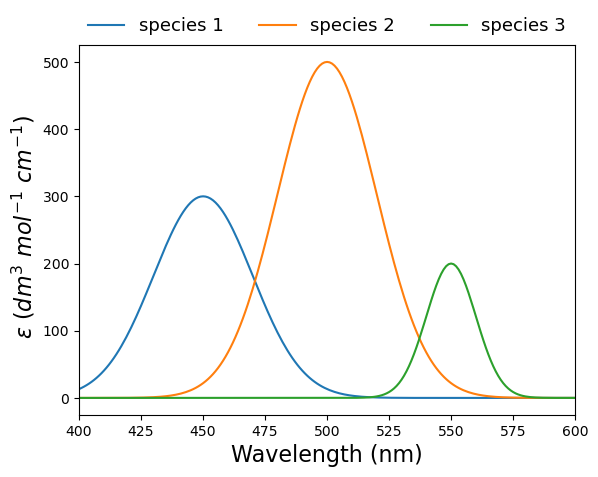

In [8]:
muWL_L=(450,500,550)
sigma_L=(20,20,10)
epsilon=[300,500, 200] # molar extinction coeffcients
WL_arr=np.arange(400,900,1)


Spdict={}

for i,  (mu, sigma, eps) in enumerate(zip(muWL_L, sigma_L, epsilon)):
    Spdict[f'species {i+1}'] = (Gau(WL_arr, mu, sigma)*eps/np.max(Gau(WL_arr, mu, sigma)))

fig1, ax1 = plt.subplots()

Sp=pd.DataFrame(Spdict)
Sp.index=WL_arr
Sp.columns.size
Sp.plot(ax=ax1, legend=True)
ax1.set_xlim(400,600)
# ledgend with no frame, horizontal and above plot

ax1.legend(frameon=False, loc='upper center', bbox_to_anchor=(0.5, 1.12), ncol=3, fontsize=13)

ax1.set_xlabel('Wavelength (nm)', fontsize=16)
ax1.set_ylabel(r' $\epsilon \ (dm^3 \ mol^{-1} \ cm^{-1})$ ', fontsize=16)




Let's now assume we start with a 1 mM solution of species 1 (denoted as $C_T$)- let's generate our starting spectra as we know our starting concentrations. For simplicty here we will work with a 1 cm path length such that $\epsilon*C=A$

If species 1 forms species 2:

Mass balance: $C_1+C_2=C_T$ 


The extent of reaction can be defined as $\theta = C_2/(C_1+C_2)=C_2/(C_T) $ Thus $\theta*C_T=C_2$

$C_1=C_T-C2$

We can now define the absorption in terms of the extent of reaction:


as $A = A_1+A2=\epsilon_1 C_1 +\epsilon_2 C_2$

$A = A_1+A2=\epsilon_1 (C_T-\theta C_T) +\epsilon_2 C_T \theta  $

$A=\epsilon_1 C_T -\epsilon_1 \theta C_T +\epsilon_2 C_T \theta$

$A-\epsilon_1 C_T=\epsilon_2 C_T \theta -\epsilon_1 C_T \theta $

$A-\epsilon_1 C_T = \theta (\epsilon_2 C_T  -\epsilon_1  C_T)$

$\frac{A-\epsilon_1 C_T}{\epsilon_2 C_T  -\epsilon_1  C_T} =\theta $

If the system is at eqm:

$\Delta G=\Delta G^0 + RTln(Q)=\Delta G^0 + RTln(\frac{C2}{C1})$ 

as $\theta = \frac{1}{(1+ C_1/C_2)}$

$ \theta = \frac{1}{(1+\frac{1}{Q})}$

$ Q = \frac{1}{(\frac{1}{\theta}-1)}$


$\Delta G = \Delta G^0 + RTln(\frac{1}{\frac{1}{\theta}-1})$ 




How do we interpret this?
$\theta =\frac{A-\epsilon_1 C_T}{\epsilon_2 C_T  -\epsilon_1  C_T}=\frac{A-A_1^{initial}}{A_2^{final}  -A_1^{initial}}= A'_\theta$

i.e. the extent is the change from the intial spectrum over the total change possible - checks out!

Now we just reorganise the thermodynamcs:

$e^{\frac{\Delta G - \Delta G^0}{RT}}=Q=\frac{1}{(\frac{1}{\theta}-1)}$

$\frac{1}{e^{(\frac{\Delta G - \Delta G^0}{RT})^{-1}}+1}=\theta=\frac{A-A_1^{initial}}{A_2^{final}  -A_1^{initial}}= A'_\theta$




In [9]:
theta=np.arange(0,1,0.01) #  theta values to model reaction progress
CT=0.001 # in mol
C2=CT*theta
C1=CT-C2

A1=np.zeros((len(Sp1),len(theta)))
A2=np.zeros((len(Sp2),len(theta)))
A3=np.zeros((len(Sp3),len(theta)))

for i in range(A1.shape[1]):
    A1[:,i]=Sp1*C1[i]
    A2[:,i]=Sp2*C2[i]
    A3[:,i]=Sp3*C2[i]

A1=pd.DataFrame(A1)
A2=pd.DataFrame(A2)
A3=pd.DataFrame(A3)

A1.columns=theta
A1.index=WL_arr
A2.columns=theta
A2.index=WL_arr
A3.columns=theta
A3.index=WL_arr

n=A1.shape[1]

n=A1.shape[1]
cmap = cmc.roma
cmap1 = cmc.roma

colors=cmap(np.linspace(0,1,n))
colors1=cmap1(np.linspace(0,1,n))


AT=A1+A2+A3

AT.columns=theta
AT.index=WL_arr
fig, ax = plt.subplots()
AT.plot(legend=False, colormap=cmc.roma, ax=ax)
# create a color bar
sm = plt.cm.ScalarMappable(cmap=cmc.roma, norm=plt.Normalize(vmin=AT.columns.values.min(), vmax=AT.columns.values.max()))
fig.colorbar(sm, ax=ax, orientation='vertical', label='Conversion')
# create a color bar
plt.xlim(400,575)
plt.ylim(0,0.6)

plt.ylabel('A') 
plt.xlabel('Wavelength (nm)')
cmap='viridis'



Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/benj/anaconda3/envs/SpEC/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
    ~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/vm/d986p9hx0rlglk34b43v_h180000gn/T/ipykernel_8209/2486560288.py", line 6, in <module>
    A1=np.zeros((len(Sp1),len(theta)))
                     ^^^
NameError: name 'Sp1' is not defined. Did you mean: 'Sp'?

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/benj/anaconda3/envs/SpEC/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 2168, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
        etype, value, tb, tb_offset=tb_offset
    )
  File "/Users/benj/anaconda3/envs/SpEC/lib/python3.13/site-packages/IPython/core/ultratb.py", line 1454, in structured_traceback
    return FormattedTB.structu

In [ ]:
Delta_G=np.arange(-4000,3e4,10) # energy is in joules so big numbers needed for rxn energies measured in 100s of kJ mol-1
G0=1e4 # wont use it in the equations but implicit

F=np.exp((Delta_G-G0)/(constants.gas_constant*298)) # gas const
Theta_Calc=1/((1/F)+1)



plt.plot(Delta_G, Theta_Calc)
plt.ylabel('$ θ $') 
plt.xlabel('$\Delta G$ (J)')


In [ ]:
C2_calc=Theta_Calc*CT
C3_calc=Theta_Calc*CT
C1_calc=CT-Theta_Calc*CT
plt.plot(Delta_G, C1_calc)
plt.plot(Delta_G, C2_calc)
plt.plot(Delta_G, C3_calc, linestyle='--')

plt.ylabel('$ C \ (M) $') 
plt.xlabel('$\Delta G$ (J)')



In [ ]:
Max1=np.max(epsilon[0])
Max2=np.max(epsilon[1])
Max3=np.max(epsilon[2])


A2_G=C2_calc*Max1
A1_G=C1_calc*Max2
A3_G=C2_calc*Max3

plt.plot(Delta_G, A1_G)
plt.plot(Delta_G, A2_G)
plt.plot(Delta_G, A3_G)

plt.ylabel('$A$') 
plt.xlabel('$\Delta G$ (J)')


In [ ]:
Delta_epsilon=Sp2-Sp1
plt.plot(WL_arr,Delta_epsilon)
plt.xlim(400,575)
plt.ylabel('$\Delta \epsilon  \ (M^{-1} \ cm^{-1})$') 
plt.xlabel('Wavelength (nm)') 
plt.rcParams.update({'font.size':20})
